In [1]:
from itertools import product
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

**Files description**

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.


### Loading data

In [2]:
data_path = os.path.join('datasets', 'future_sales')

sales_train_path = os.path.join(data_path, 'sales_train.csv')
train_df = pd.read_csv(sales_train_path)

test_path = os.path.join(data_path, 'test.csv')
test_df = pd.read_csv(test_path)

items_path = os.path.join(data_path, 'items.csv')
temp_df = pd.read_csv(items_path)
train_df = pd.merge(train_df, temp_df, on='item_id', how='left')

items_category_path = os.path.join(data_path, 'item_categories.csv')
temp_df = pd.read_csv(items_category_path)
train_df = pd.merge(train_df, temp_df, on='item_category_id', how='left')

shops_path = os.path.join(data_path, 'shops.csv')
temp_df = pd.read_csv(shops_path)
train_df = pd.merge(train_df, temp_df, on='shop_id', how='left')

print('Shape: ', train_df.shape)

Shape:  (2935849, 10)


### Data Fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### Removing not useful rows

There are a lot of different shop_ids and item_ids in train set which are not present in testset. I assume that using them is pointless for predictions. That why I remove every combination of shop_id and item_id which is present in train set but is absent in test set

In [3]:
test_shop_id = test_df['shop_id'].unique()
test_item_id = test_df['item_id'].unique()

train_df = train_df.loc[train_df['shop_id'].isin(test_shop_id)]
train_df = train_df.loc[train_df['item_id'].isin(test_item_id)]
train_df.shape

(1224439, 10)

In this notebook I will not try to extract any information from string features so I am removing them completely

In [4]:
train_df.drop(columns=['item_name', 'item_category_name', 'shop_name'], inplace=True)
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
10,03.01.2013,0,25,2574,399.0,2.0,55
11,05.01.2013,0,25,2574,399.0,1.0,55
12,07.01.2013,0,25,2574,399.0,1.0,55
13,08.01.2013,0,25,2574,399.0,2.0,55


## Visualisations

In [5]:
train_df['sales'] = train_df['item_price'] * train_df['item_cnt_day']

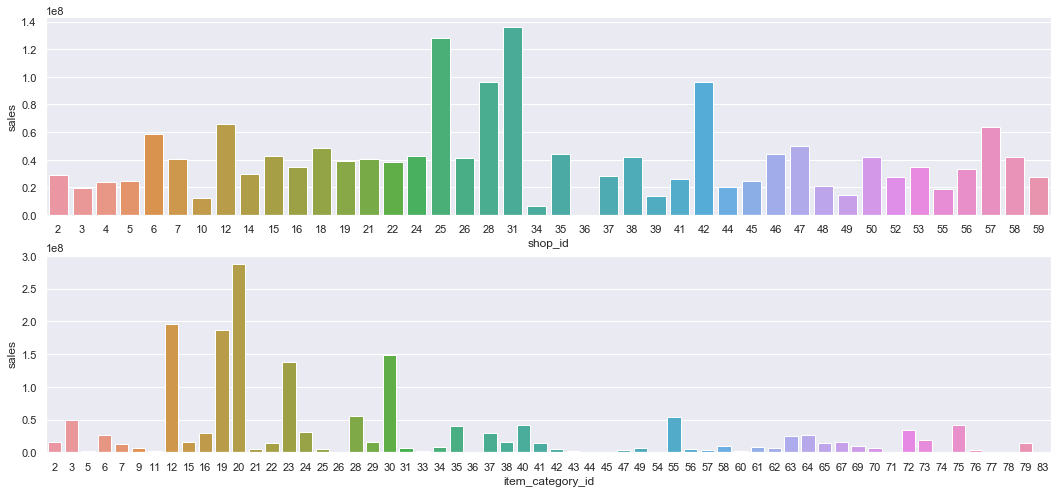

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(18,8))
total_shop = train_df.groupby('shop_id', as_index=False)['sales'].sum()
sns.barplot(x='shop_id', y='sales', data=total_shop, ax=ax[0])

total_shop = train_df.groupby('item_category_id', as_index=False)['sales'].sum()
sns.barplot(x='item_category_id', y='sales', data=total_shop, ax=ax[1])

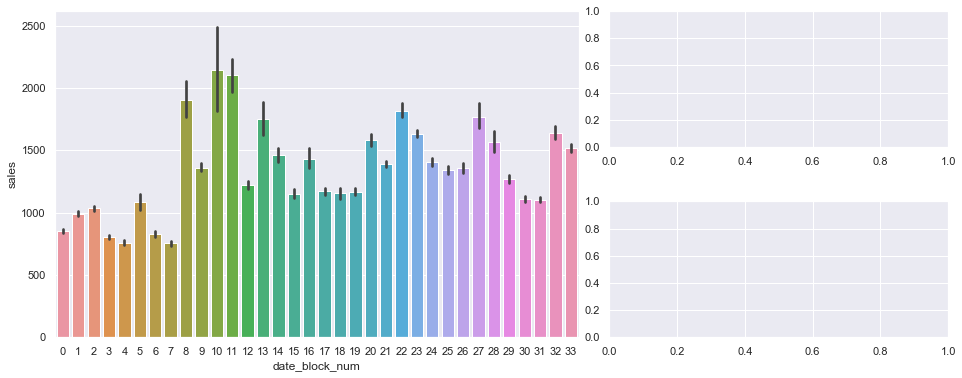

In [7]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(2, 5, hspace=0.4)

ax1 = fig.add_subplot(grid[:, 0:3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, 3:])
date_block_group = train_df.groupby('date_block_num')
sns.barplot(x='date_block_num', y='sales', data=train_df, ax=ax1)

### Grouping by month

Test set and train set is in very different format. In train set every single transaction is one row. That is why one of features is date. However the purpose of modelling is to predict future number of product sold for every shop_id and item_id by month - not by date. That is why it is necessary to group by all transaction in one month in train set. The best way is to use features date_block_num (number of month from beginning), shop_id and item_id for grouping.

In [8]:
cols_to_group = ['date_block_num', 'shop_id', 'item_category_id', 'item_id']
train_group = train_df.groupby(cols_to_group).agg({'item_price': [np.mean, np.sum],
                                                   'item_cnt_day': [np.mean, np.sum]})
train_group.reset_index(inplace=True)
train_group.columns = cols_to_group + ['price_mean', 'price', 'cnt_mean', 'cnt']

In [9]:
shop_ids = train_group['shop_id'].unique()
item_ids = train_group['item_id'].unique()
date_blocks = train_group['date_block_num'].unique()
empty_df = list(product(date_blocks, shop_ids, item_ids))
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
all_train = pd.merge(empty_df, train_group, on=['date_block_num','shop_id','item_id'], how='left')
all_train.fillna(0, inplace=True)

In [10]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.0,16.500000,9.810709,0.0,8.00,16.5,25.00,33.000000
shop_id,6734448.0,31.642857,17.561894,2.0,16.00,34.5,47.00,59.000000
item_id,6734448.0,11041.890161,6210.744436,30.0,5385.25,11265.5,16068.25,22167.000000
item_category_id,6734448.0,3.786271,13.212956,0.0,0.00,0.0,0.00,83.000000
price_mean,6734448.0,81.230111,534.732650,0.0,0.00,0.0,0.00,42990.000000
price,6734448.0,187.392884,2177.443736,0.0,0.00,0.0,0.00,515573.589744
cnt_mean,6734448.0,0.097299,0.612203,-2.0,0.00,0.0,0.00,1000.000000
cnt,6734448.0,0.240223,3.456640,-4.0,0.00,0.0,0.00,2253.000000


### EDA

Removing outliers

percentage of obs with cnt more than 20:  6078
percentage of obs with cnt less than 0:  252
percentage of obs with price more than 400 000:  11


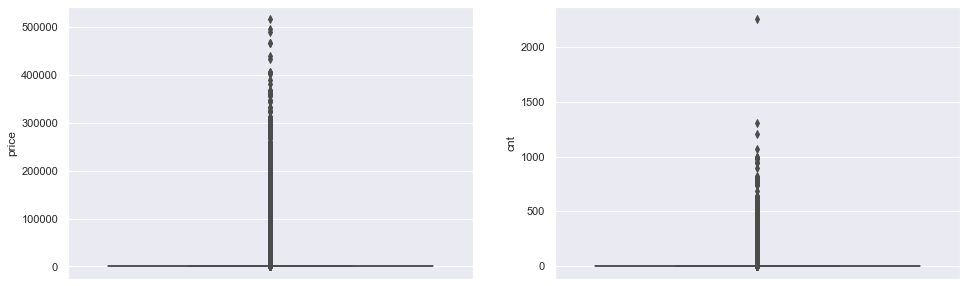

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(y=all_train['price'], ax=ax1)
sns.boxplot(y=all_train['cnt'], ax=ax2)

print('percentage of obs with cnt more than 20: ', all_train[all_train['cnt'] > 20].shape[0])
print('percentage of obs with cnt less than 0: ', all_train[all_train['cnt'] < 0].shape[0])
print('percentage of obs with price more than 400 000: ', all_train[all_train['price'] > 400_000].shape[0])

In [12]:
all_train = all_train.loc[(all_train['cnt'] <= 20) 
                          & (all_train['cnt'] >= 0) 
                          & (all_train['price'] < 400_000)].copy()

In [13]:
def get_year(x):
    return x // 12 + 2013

def get_month(x):
    return x % 12

all_train['year'] = all_train['date_block_num'].apply(get_year)
all_train['month'] = all_train['date_block_num'].apply(get_month)
all_train['sales'] = all_train['cnt'] * all_train['price']

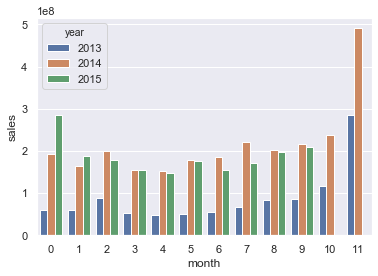

In [14]:
temp = all_train.groupby(['year', 'month'])[['price', 'cnt', 'sales']].sum()
temp.reset_index(inplace=True)
sns.barplot(x='month', y='sales', hue='year', data=temp)

### String Features

In [15]:
items_path = os.path.join(data_path, 'items.csv')
item_df = pd.read_csv(items_path)

items_category_path = os.path.join(data_path, 'item_categories.csv')
category_df = pd.read_csv(items_category_path)

shops_path = os.path.join(data_path, 'shops.csv')
shop_df = pd.read_csv(shops_path)

In [16]:
shop_df['city'] = shop_df['shop_name'].str.split().str[0]
shop_df['city'].replace('!Якутск', 'Якутск', inplace=True)
shop_encoder = LabelEncoder()
shop_df['city_code'] = shop_encoder.fit_transform(shop_df['city'])
shop_df.drop(columns=['shop_name', 'city'], inplace=True)

In [17]:
category_df['category_type'] = category_df['item_category_name'].str.split().str[0]
cat_encoder = LabelEncoder()
category_df['cat_code'] = cat_encoder.fit_transform(category_df['category_type'])
category_df.drop(columns=['item_category_name', 'category_type'], inplace=True)

In [18]:
all_train = pd.merge(all_train, shop_df, on='shop_id')
all_train = pd.merge(all_train, category_df, on='item_category_id')

## Feature engineering

In [19]:
cols_to_group = ['shop_id', 'item_category_id', 'item_id']
all_train['lag_price'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['price'].shift(-1)
all_train['lag_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-1)
all_train['lag_2_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-2)
all_train['lag_3_cnt'] = all_train.sort_values('date_block_num').groupby(cols_to_group)['cnt'].shift(-3)
cols = ['lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'lag_price']
all_train[cols] = all_train[cols].fillna(0)

In [20]:
rolling_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
rolling_min = lambda x: x.rolling(window=3, min_periods=1).min()
rolling_max = lambda x: x.rolling(window=3, min_periods=1).max()

all_train['rolling_mean_cnt'] = all_train.sort_values('date_block_num') \
                                         .groupby(cols_to_group)['cnt'].apply(rolling_mean)
all_train['rolling_min_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_min)
all_train['rolling_max_cnt'] = all_train.sort_values('date_block_num') \
                                        .groupby(cols_to_group)['cnt'].apply(rolling_max)

In [21]:
all_train['change_cnt'] = all_train['cnt'] - all_train['lag_cnt']
all_train['change_2_cnt'] = all_train['cnt'] - all_train['lag_2_cnt']
all_train['change_3_cnt'] = all_train['cnt'] - all_train['lag_3_cnt']

In [22]:
all_train['target'] = all_train.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['cnt'].shift(1)

In [23]:
all_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.498777,9.811429,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.643428,17.563488,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.868904,6209.703870,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.752608,13.156585,0.0,0.0,0.0,0.0,83.0
price_mean,6728118.0,79.816626,525.620638,0.0,0.0,0.0,0.0,42990.0
price,6728118.0,169.801052,1797.753805,0.0,0.0,0.0,0.0,366860.0
cnt_mean,6728118.0,0.093249,0.312189,0.0,0.0,0.0,0.0,20.0
cnt,6728118.0,0.185153,0.907449,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.941146,0.802274,2013.0,2013.0,2014.0,2015.0,2015.0
month,6728118.0,5.205026,3.323107,0.0,2.0,5.0,8.0,11.0


## One item

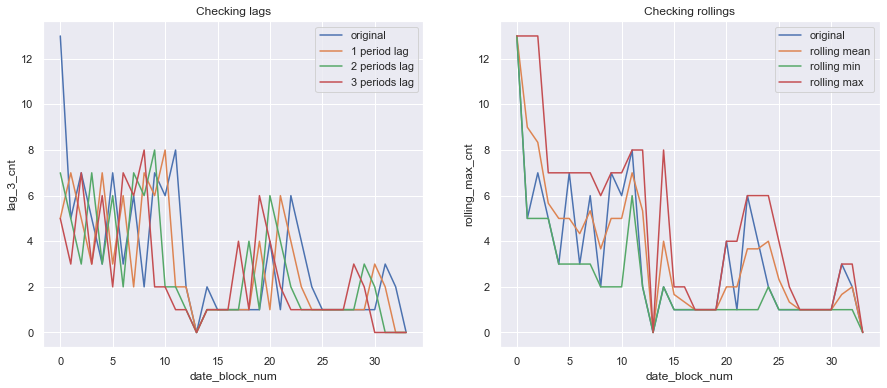

In [24]:
one_item = all_train.loc[(all_train['shop_id'] == 25) & (all_train['item_id'] == 8093)]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[0], label='original')
sns.lineplot(x='date_block_num', y='lag_cnt', data=one_item, ax=ax[0], label='1 period lag')
sns.lineplot(x='date_block_num', y='lag_2_cnt', data=one_item, ax=ax[0], label='2 periods lag')
sns.lineplot(x='date_block_num', y='lag_3_cnt', data=one_item, ax=ax[0], label='3 periods lag')
ax[0].legend()
ax[0].set_title('Checking lags')

sns.lineplot(x='date_block_num', y='cnt', data=one_item, ax=ax[1], label='original')
sns.lineplot(x='date_block_num', y='rolling_mean_cnt', data=one_item, ax=ax[1], label='rolling mean')
sns.lineplot(x='date_block_num', y='rolling_min_cnt', data=one_item, ax=ax[1], label='rolling min')
sns.lineplot(x='date_block_num', y='rolling_max_cnt', data=one_item, ax=ax[1], label='rolling max')
ax[1].legend()
ax[1].set_title('Checking rollings');

In [25]:
one_item.head()

,date_block_num,shop_id,item_id,item_category_id,price_mean,price,cnt_mean,cnt,year,month,...,lag_cnt,lag_2_cnt,lag_3_cnt,rolling_mean_cnt,rolling_min_cnt,rolling_max_cnt,change_cnt,change_2_cnt,change_3_cnt,target
199095,0,25,8093,38.0,1312.085238,9184.596667,1.857143,13.0,2013,0,...,5.0,7.0,5.0,13.000000,13.0,13.0,8.0,6.0,8.0,NaN
199109,1,25,8093,38.0,1353.023750,5412.095000,1.250000,5.0,2013,1,...,7.0,5.0,3.0,9.000000,5.0,13.0,-2.0,0.0,2.0,13.0
199120,2,25,8093,38.0,1381.414286,9669.900000,1.000000,7.0,2013,2,...,5.0,3.0,7.0,8.333333,5.0,13.0,2.0,4.0,0.0,5.0
199131,3,25,8093,38.0,1399.000000,6995.000000,1.000000,5.0,2013,3,...,3.0,7.0,3.0,5.666667,5.0,7.0,2.0,-2.0,2.0,7.0
199148,4,25,8093,38.0,1399.000000,4197.000000,1.000000,3.0,2013,4,...,7.0,3.0,6.0,5.000000,3.0,7.0,-4.0,0.0,-3.0,5.0


In [26]:
all_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.0,16.50,9.81,0.0,8.0,16.0,25.0,33.0
shop_id,6728118.0,31.64,17.56,2.0,16.0,35.0,47.0,59.0
item_id,6728118.0,11042.87,6209.70,30.0,5386.0,11266.0,16068.0,22167.0
item_category_id,6728118.0,3.75,13.16,0.0,0.0,0.0,0.0,83.0
price_mean,6728118.0,79.82,525.62,0.0,0.0,0.0,0.0,42990.0
price,6728118.0,169.80,1797.75,0.0,0.0,0.0,0.0,366860.0
cnt_mean,6728118.0,0.09,0.31,0.0,0.0,0.0,0.0,20.0
cnt,6728118.0,0.19,0.91,0.0,0.0,0.0,0.0,20.0
year,6728118.0,2013.94,0.80,2013.0,2013.0,2014.0,2015.0,2015.0
month,6728118.0,5.21,3.32,0.0,2.0,5.0,8.0,11.0


### Preprocessing

In [27]:
df = all_train.loc[all_train['date_block_num'] > 2].copy()

In [28]:
columns = ['lag_price', 'lag_cnt', 'lag_2_cnt', 'lag_3_cnt', 'rolling_mean_cnt',
           'rolling_min_cnt', 'rolling_max_cnt', 'target']
for col in columns:
    print(col)
    temp = df.groupby(['shop_id'])[col].median()
    df = pd.merge(df, temp, left_on='shop_id', right_index=True, suffixes=('', '_y'), how='left')
    df.loc[df[col].isna(), col] = df[f'{col}_y']
    df.drop(columns=f'{col}_y', inplace=True)

col_means = df[columns].mean()
df[columns].fillna(col_means, inplace=True)

lag_price
lag_cnt
lag_2_cnt
lag_3_cnt
rolling_mean_cnt
rolling_min_cnt
rolling_max_cnt
target


C:\Users\Bartek\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [29]:
df.isna().sum().any()

False

## Machine learning

In [30]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

I will use only months from 4 to 28 (first three are removed before) as training data and last 5 months (from 28 to 33) as validation data. As a result validation data is almost 20% and training data about 80% of all data.

In [31]:
train_df = df.loc[df['date_block_num'] < 28].copy()
valid_df = df.loc[df['date_block_num'] >= 28].copy()

for set_ in [train_df, valid_df]:
    set_.drop(columns=['date_block_num', 'sales'], inplace=True)
print(f'Valid split: {valid_df.shape[0] / (train_df.shape[0] + valid_df.shape[0])}')

Valid split: 0.19357719407668333


### Let's get some means

Probably it is a good idea to use means of few columns. Means of number of product sold for every shop_id, item_id and category_id are obvious choices. Additionally I think mean of every month can be also useful. It seems reasonable to assume that if month was not very profitable in the past I will be not in the future. Of course there are a lot of different possible other combinations. However they turn out not really useful. That is why I will stay with only five:
1. Mean for every shop_id
2. Mean for every item_id
3. Mean for every shop_id and item_id
4. Mean for every item_category_id
5. Mean for every month

**Finally it is important to use that after splitting to avoid data leakage.**

In [32]:
shop_mean = train_df.groupby('shop_id')['cnt'].mean()
shop_mean = shop_mean.reset_index()
shop_mean.rename(columns={'cnt': 'shop_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_mean, on='shop_id', how='left')
valid_df = pd.merge(valid_df, shop_mean, on='shop_id', how='left')

item_mean = train_df.groupby('item_id')['cnt'].mean()
item_mean = item_mean.reset_index()
item_mean.rename(columns={'cnt': 'item_mean'}, inplace=True)
train_df = pd.merge(train_df, item_mean, on='item_id', how='left')
valid_df = pd.merge(valid_df, item_mean, on='item_id', how='left')

shop_item_mean = train_df.groupby(['shop_id', 'item_id'])['cnt'].mean()
shop_item_mean = shop_item_mean.reset_index()
shop_item_mean.rename(columns={'cnt': 'shop_item_mean'}, inplace=True)
train_df = pd.merge(train_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')
valid_df = pd.merge(valid_df, shop_item_mean, on=['shop_id', 'item_id'], how='left')

category_mean = train_df.groupby('item_category_id')['cnt'].mean()
category_mean = category_mean.reset_index()
category_mean.rename(columns={'cnt': 'category_mean'}, inplace=True)
train_df = pd.merge(train_df, category_mean, on='item_category_id', how='left')
valid_df = pd.merge(valid_df, category_mean, on='item_category_id', how='left')

month_mean = train_df.groupby('month')['cnt'].mean()
month_mean = month_mean.reset_index()
month_mean.rename(columns={'cnt': 'month_mean'}, inplace=True)
train_df = pd.merge(train_df, month_mean, on='month', how='left')
valid_df = pd.merge(valid_df, month_mean, on='month', how='left')

In [33]:
X_train = train_df.drop(columns='target')
Y_train = train_df['target']

X_valid = valid_df.drop(columns='target')
Y_valid = valid_df['target']

In [42]:
def get_model_report(X_valid, Y_valid, model, cols):
    Y_pred = model.predict(X_valid[cols].fillna(0))
    rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred))
    r_score = r2_score(Y_valid, Y_pred)
    print(f'RMSE: {rmse.round(3)}\tR2: {r_score.round(3)}')

    x = pd.DataFrame(list(zip(X_train[cols].columns, model.feature_importances_)), 
                     columns=['feature', 'imp'])
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    sns.barplot(y='feature', x='imp', 
                data=x.sort_values('imp', ascending=False),
                ax=ax[0])
    ax[1].scatter(Y_valid, Y_pred)
    ax[1].set(xlabel='Actual', ylabel='Predicted')

In [36]:
from xgboost import XGBRegressor

xgb_columns = ['rolling_mean_cnt', 'rolling_max_cnt', 'shop_item_mean', 
               'change_3_cnt', 'cnt', 'rolling_min_cnt', 'change_2_cnt', 
               'year', 'month', 'cnt_mean']

xgb_model = XGBRegressor(max_depth=6,
                         n_estimators=500, 
                         verbosity=2)
xgb_model.fit(X_train[xgb_columns], Y_train,
              eval_metric='rmse',
              eval_set=[(X_train[xgb_columns], Y_train), (X_valid[xgb_columns], Y_valid)], 
              verbose=True, 
              early_stopping_rounds=20)

[23:03:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[23:03:43] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-rmse:0.77969	validation_1-rmse:0.81092
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[23:03:46] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-rmse:0.65913	validation_1-rmse:0.72891
[23:03:49] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree prun

[23:05:26] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[34]	validation_0-rmse:0.46605	validation_1-rmse:0.60050
[23:05:29] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[35]	validation_0-rmse:0.46562	validation_1-rmse:0.60033
[23:05:32] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[36]	validation_0-rmse:0.46534	validation_1-rmse:0.60085
[23:05:35] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tree\updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[37]	validation_0-rmse:0.46498	validation_1-rmse:0.60018
[23:05:38] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\tr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=2)

RMSE: 0.592	R2: 0.583


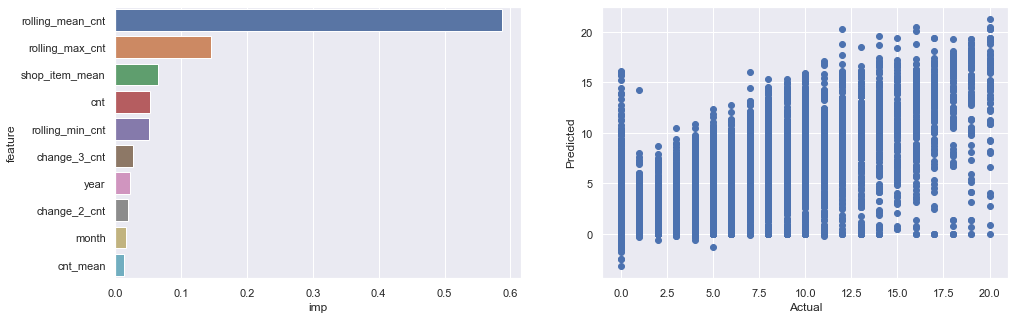

In [43]:
get_model_report(X_valid, Y_valid, xgb_model, cols=xgb_columns)